# Hands-on: Deciphering Inka Khipu Signs


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_multi_proportion_confint_digits(actual_first_digit_frequencies, 
                                         actual_first_digit_counts, 
                                         expected_first_digit_frequencies,
                                         label_actual,
                                         label_expected,
                                         title
                                        ):
    # Import function-specific package:
    from statsmodels.stats.proportion import multinomial_proportions_confint
    
    # Plot 95% CIs as lines with caps on the top and bottom for easier interpretation
    plt.figure(figsize=(9,5))

    (_, caps, _) = plt.errorbar(x=np.arange(1, 10, 1), 
                     y=actual_first_digit_frequencies, 
                     yerr=[(top-bot)/2 for top,bot in multinomial_proportions_confint(actual_first_digit_counts)],
                     capsize=5, fmt='none', label=label_actual+' 95% CI')

    for cap in caps:
        cap.set_markeredgewidth(1)

    # Plot expected values as scatter plot points, in order to visualize where CIs include expected values
    plt.scatter(np.arange(1,10,1), expected_first_digit_frequencies, label=label_expected, color='red')
    
    # Format 
    plt.xticks([1,2,3,4,5,6,7,8,9])
    plt.xlabel('First Digits')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend();
    
    return

### Checking Benford's Law with Demographic Data
I downloaded 2010 US Census Data of the population size for all the different counties in the United States. The first digits of the population sizes should follow Benford's Law closely. Let's see...

In [2]:
population_df = pd.read_csv('Population_by_County_2010_Census.csv')

In [3]:
population_df.head()

,GEO.id,GEO.id2,Geography,Population
0,0500000US01001,1001,"Autauga County, Alabama",54571
1,0500000US01003,1003,"Baldwin County, Alabama",182265
2,0500000US01005,1005,"Barbour County, Alabama",27457
3,0500000US01007,1007,"Bibb County, Alabama",22915
4,0500000US01009,1009,"Blount County, Alabama",57322


In [4]:
population_size = population_df['Population']

In [5]:
# Function returns first digit of the number it takes as a parameter:
def first_digit(number):
    return int(str(number)[0])

In [6]:
first_digits_population_size = population_size.apply(first_digit)

In [7]:
first_digit_frequencies = first_digits_population_size.value_counts()/len(first_digits_population_size)
first_digit_frequencies.sort_index(inplace=True)
first_digit_frequencies

1    0.303310
2    0.189052
3    0.119032
4    0.098027
5    0.067791
6    0.066836
7    0.057925
8    0.048377
9    0.049650
Name: Population, dtype: float64

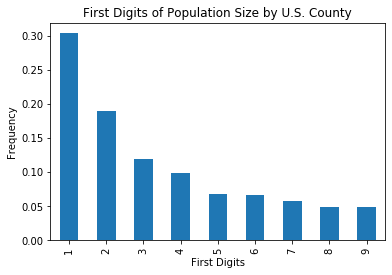

In [8]:
first_digit_frequencies.plot(kind='bar',title='First Digits of Population Size by U.S. County')
plt.xlabel('First Digits')
plt.ylabel('Frequency');

This looks a lot like what [Benford's Law](https://en.wikipedia.org/wiki/Benford%27s_law) Predicts. Let's plot the theoretical predictions to see if visually they look the same...

In [9]:
expected_frequencies = pd.Series([.301, .176, .125, .097, .079, .067, .058, .051, .046], index=[1,2,3,4,5,6,7,8,9])
freqs = pd.DataFrame([first_digit_frequencies, expected_frequencies]).T
freqs.columns = ['Actual', 'Expected']

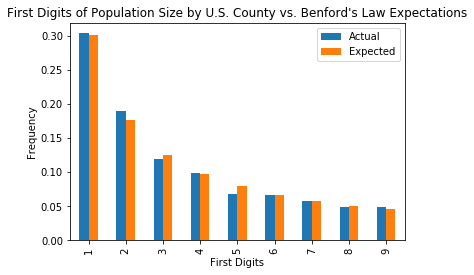

In [10]:
freqs.plot(kind='bar', title='First Digits of Population Size by U.S. County vs. Benford\'s Law Expectations')
plt.xlabel('First Digits')
plt.ylabel('Frequency');

We can also assess similarity statistically through a statistical test like a chi-square test. We can see that first digits are not so different as to be considered statistically significant.

In [11]:
from scipy.stats import chisquare
actual_counts = first_digits_population_size.value_counts()
expected_counts = expected_frequencies*len(first_digits_population_size)
chisquare(actual_counts, f_exp=expected_counts)

Power_divergenceResult(statistic=9.522569120793193, pvalue=0.3001453330051994)

Using a single statistic as a measure for systematic divergence across the distribution makes it difficult to interpret individual divergences of first digits, though. Let's plot each digit's 95% confidence interval as well to see if there are any individual divergences.

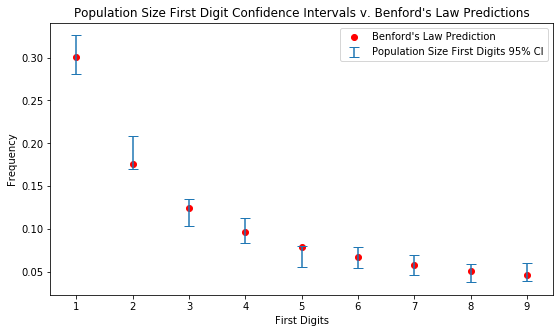

In [12]:
plot_multi_proportion_confint_digits(actual_first_digit_frequencies = first_digit_frequencies,
                                        actual_first_digit_counts = actual_counts,
                                        expected_first_digit_frequencies = expected_frequencies,
                                        label_actual = 'Population Size First Digits',
                                        label_expected = 'Benford\'s Law Prediction',
                                        title = 'Population Size First Digit Confidence Intervals v. Benford\'s Law Predictions'
                                       )

### Testing Anomalous Khipu Cords for Adherence to Benford's Law

* Data derived from MySQL data tables at: http://khipukamayuq.fas.harvard.edu/DataTables.html

* Goal: test anomalous first digit distribution versus Benford's Law and vs. random uniform sum distribution.
    * Cord values (summations of knots' customary numerical values) should not overlap with the Benford's Law distribution if they have non-numerical interpretants.
    * Random summations of knots on a cord would have a distribution similar to a distribution of two uniform random integers (1-9) summed together (average number of knots on an anomalous cord is 2). Thus, should only overlap with random uniform distribution if these cords have non-numerical interpretants (i.e. the normal numerical value of the knot does not apply and it takes on non-numerical characteristics).
    
Let's take a look at the difference in what our expectations might look like under a uniform sum model vs. a Benford's Law model

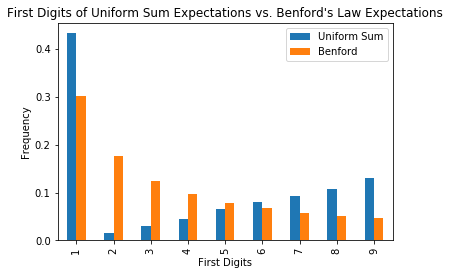

In [13]:
# Set a Random Seed for Reproducibility
np.random.seed(0)

# Simulate 10k summations of random integers (mirroring sums of anomalous values -- two levels being the most common number of knot levels)
uniform_sum = np.random.randint(1,9,10000) + np.random.randint(1,9,10000)

#Identify first digits of the simulated values
first_digit_uniform = pd.Series(uniform_sum).apply(first_digit)
uniform_first_digit_frequencies = first_digit_uniform.value_counts()/len(first_digit_uniform)
uniform_first_digit_frequencies.sort_index(inplace=True)

freqs_expected_distributions = pd.DataFrame([uniform_first_digit_frequencies, expected_frequencies]).T
freqs_expected_distributions.columns = ['Uniform Sum', 'Benford']
freqs_expected_distributions.plot(kind='bar', title='First Digits of Uniform Sum Expectations vs. Benford\'s Law Expectations')
plt.xlabel('First Digits')
plt.ylabel('Frequency');

In [14]:
'''
Complicated cleaning process, so I'm just going to read in pre-cleaned data that I've accessed from the database. Can see
that it's highly structured -- with values derived from cord level data tables in the SQL database. I've labeled whether
or not a cord is Anomalous already, so this step is taken care for us.

'''

khipu_cords = pd.read_pickle('khipu_cords.pkl')
khipu_cords.tail()

,Unnamed: 0,Khipu,Cord,Fiber,Value,Colors,Spin_Ply,Attachment,Termin,Length,Anomalous
56822,3146,UR294,1,CN,100,LB,Z,V,K,34.5,False
56823,3147,UR294,2,CN,22,MB,Z,V,B,22.5,False
56824,3148,UR294,3,CN,65,NB,Z,V,K,17.5,False
56825,3149,UR294,4,CN,52,W,Z,V,K,23.0,False
56826,3150,UR294,5,CN,0,MB\t (0-23) \r\nMB:W:BG\t (23-27) \r\nMB\t (27...,Z,V,K,40.5,False


In [15]:
# Find first digits of Anomalous and Normal, Lockean cord values
first_digit_anomalous = khipu_cords[khipu_cords['Anomalous'] != False]['Value'].apply(first_digit)
first_digit_normal = khipu_cords[khipu_cords['Anomalous'] == False]['Value'].apply(first_digit)

# Drop any cords that don't have a knot tied on them
first_digit_anomalous = first_digit_anomalous[first_digit_anomalous != 0]
first_digit_normal = first_digit_normal[first_digit_normal != 0]

In [16]:
# Find frequencies of first digits for Anomalous cord values
anomalous_first_digit_frequencies = first_digit_anomalous.value_counts()/len(first_digit_anomalous)
anomalous_first_digit_frequencies.sort_index(inplace=True)

# Frequencies of first digits for Normal, Lockean cord values
normal_first_digit_frequencies = first_digit_normal.value_counts()/len(first_digit_normal)
normal_first_digit_frequencies.sort_index(inplace=True)

In [17]:
freqs_cord_values = pd.DataFrame([anomalous_first_digit_frequencies, 
                                  normal_first_digit_frequencies, 
                                  expected_frequencies,
                                  uniform_first_digit_frequencies
                                 ]).T
freqs_cord_values.columns = ['Anomalous', 'Normal', 'Expected (Benford)', 'Expected (Uniform Sum)']
freqs_cord_values

,Anomalous,Normal,Expected (Benford),Expected (Uniform Sum)
1,0.329212,0.377575,0.301,0.4322
2,0.189332,0.198318,0.176,0.0163
3,0.113387,0.120762,0.125,0.0310
4,0.085129,0.095302,0.097,0.0456
5,0.060756,0.069059,0.079,0.0649
6,0.058637,0.051228,0.067,0.0805
7,0.053338,0.035941,0.058,0.0935
8,0.056164,0.030966,0.051,0.1063
9,0.054045,0.020849,0.046,0.1297


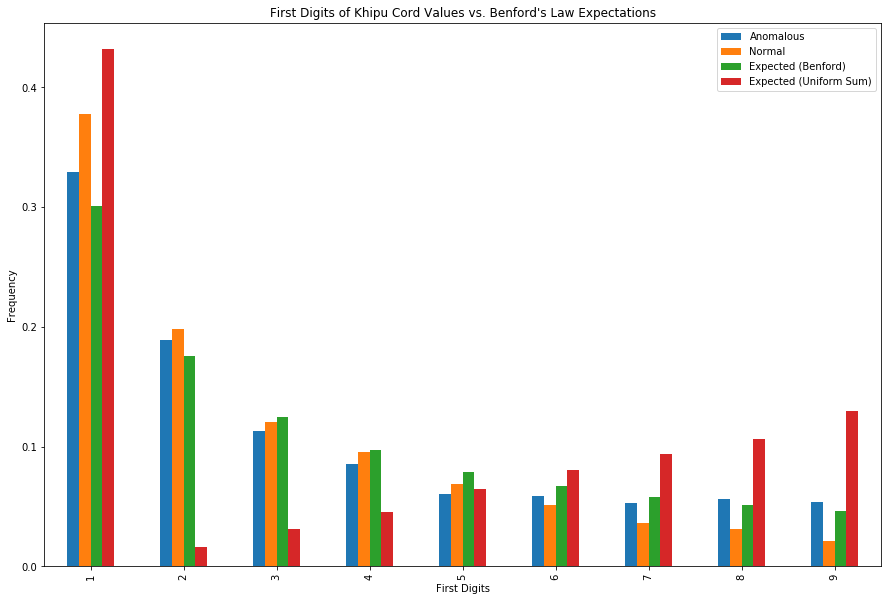

In [21]:
# Add Figsize argument so that we can see the differences between the categories a bit clearer
freqs_cord_values.plot(kind='bar', title='First Digits of Khipu Cord Values vs. Benford\'s Law Expectations', figsize=(15,10))
plt.xlabel('First Digits')
plt.ylabel('Frequency');

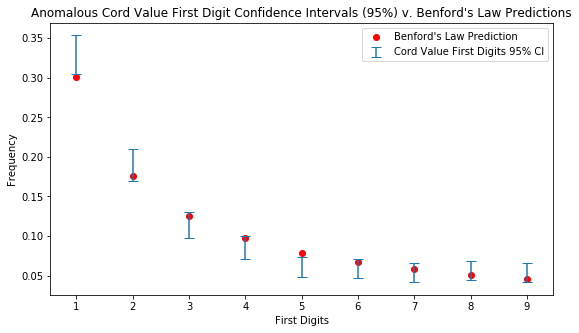

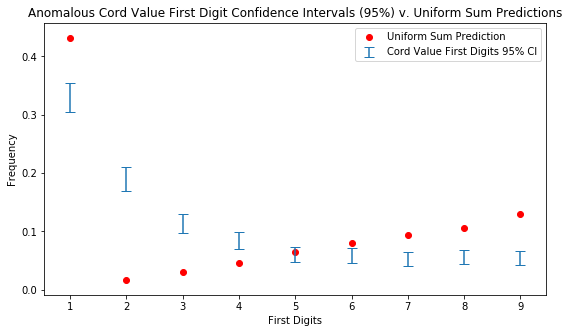

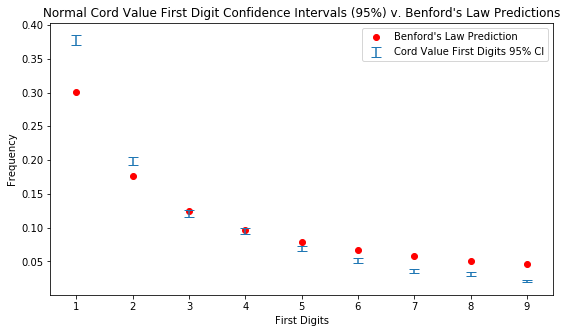

In [19]:
plot_multi_proportion_confint_digits(actual_first_digit_frequencies = anomalous_first_digit_frequencies,
                                        actual_first_digit_counts = first_digit_anomalous.value_counts(),
                                        expected_first_digit_frequencies = expected_frequencies,
                                        label_actual = 'Cord Value First Digits',
                                        label_expected = 'Benford\'s Law Prediction',
                                        title = 'Anomalous Cord Value First Digit Confidence Intervals (95%) v. Benford\'s Law Predictions'
                                       )

plot_multi_proportion_confint_digits(actual_first_digit_frequencies = anomalous_first_digit_frequencies,
                                        actual_first_digit_counts = first_digit_anomalous.value_counts(),
                                        expected_first_digit_frequencies = uniform_first_digit_frequencies,
                                        label_actual = 'Cord Value First Digits',
                                        label_expected = 'Uniform Sum Prediction',
                                        title = 'Anomalous Cord Value First Digit Confidence Intervals (95%) v. Uniform Sum Predictions'
                                       )

plot_multi_proportion_confint_digits(actual_first_digit_frequencies = normal_first_digit_frequencies,
                                        actual_first_digit_counts = first_digit_normal.value_counts(),
                                        expected_first_digit_frequencies = expected_frequencies,
                                        label_actual = 'Cord Value First Digits',
                                        label_expected = 'Benford\'s Law Prediction',
                                        title = 'Normal Cord Value First Digit Confidence Intervals (95%) v. Benford\'s Law Predictions'
                                       )

In conjunction with archaeological data showing anomalous-knotted khipus as lower-level accounting devices, anomalous cords across the Inka empire seem to have knots that are consistent with having recorded empirical, statistical information, suggesting that they had numbers as their intended interpretants instead of non-numerical values. Furthermore, given the statistically patterned use in this way, we can identify them as legisigns -- a cultural pattern of meaning.

Interestingly, "Normal" numerical cord values only seem to loosely follow Benford's Law predictions, suggesting that these values were used to record a mix of empirical data and fixed numerical values (taxes, labor duties, etc.), leading to this divergence.